### Cargando las Librerias necesarias

### Variables editables para mejorar la precision (accuracy)
 * Batch_size
 * Learning Rate
 * Optimizador
 * Imagenes (probar distintos data augmentation (investigar lo mejor para resnet))

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models, datasets
from torch.utils.data import DataLoader

### DEFINIENDO VARIABLES GLOBALES

In [2]:
import random
BATCH_SIZE = 32
EPOCHS= 50
LEARNING_RATE = 0.0001


### Carga y preprocesamiento de los datos

In [3]:
# Nuestras imagenes tienen un tamaño de 224x224
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, csv_file,img_dir,transform=None,train=True):
        #self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.train = train

        # Read the csv file
        img_labels = pd.read_csv(csv_file)

        # Split the data into train and test
        train_data, test_data = train_test_split(img_labels, test_size=0.2, random_state=42,shuffle=True)

        if self.train:
            self.data = train_data
        else:
            self.data = test_data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.data.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

## Load the ResNet-50 model without pre-trained weights

In [5]:

train_dataset = CustomDataset(csv_file='augmented_info_2.csv', img_dir='./petnet_aug_2', transform=transform, train=True)
test_dataset = CustomDataset(csv_file='augmented_info_2.csv', img_dir='./petnet_aug_2', transform=transform, train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
resnet50 = models.resnet50(weights=None)  # No pre-trained weights model.resnet50(weights=None)

## Modify the last fully connected layer for your specific task

In [7]:
num_classes = 4
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

## Set up loss function and optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=LEARNING_RATE)

In [9]:
# Definiendo funccion de accuracy per epoch
def get_accuracy(model,data_loader,device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): # No necesitamos calcular gradientes para el accuracy
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) #output es equivalente a los scores obtenidos.
            _, predicted = torch.max(outputs, 1) # Obtenemos la clase predicha
            total += labels.size(0) # Contamos el total de imagenes, para obtener el accuracy
            correct += (predicted == labels).sum().item() # Se puede guardar estos valores para obtener precision, recall, f1, etc.
    return float(correct) / total

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


## Train the entire model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50.to(device)

num_epochs = EPOCHS
#modelos = {}

#for i,rate in enumerate(RATE):
    #criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(resnet50.parameters(), lr=rate)
csv_results=[]
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()    
    acc=get_accuracy(resnet50, test_loader, device)
    #if epoch % 10 == 0:
    print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {acc},Learning_Rate:{LEARNING_RATE}')
    csv_results.append({'Epoch':epoch,'Loss':loss.item(),'Accuracy':acc,'Learning_Rate':LEARNING_RATE})
    with open(f'results.txt', 'a') as f:
            #write in json format            
        f.write(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {acc},Learning_Rate:{LEARNING_RATE}\n')
        f.close()
        #modelos[rate]=acc

csv_results_pd=pd.DataFrame(csv_results)

csv_results_pd.to_csv('results.csv',index=False)


Epoch 0, Loss: 0.6967341899871826, Accuracy: 0.7762784090909091,Learning_Rate:0.0001
Epoch 1, Loss: 0.5168529748916626, Accuracy: 0.84375,Learning_Rate:0.0001
Epoch 2, Loss: 0.43088212609291077, Accuracy: 0.8742897727272727,Learning_Rate:0.0001
Epoch 3, Loss: 0.0922289565205574, Accuracy: 0.9467329545454546,Learning_Rate:0.0001
Epoch 4, Loss: 0.07582747936248779, Accuracy: 0.9595170454545454,Learning_Rate:0.0001
Epoch 5, Loss: 0.13055472075939178, Accuracy: 0.9758522727272727,Learning_Rate:0.0001
Epoch 6, Loss: 0.011443176306784153, Accuracy: 0.9758522727272727,Learning_Rate:0.0001
Epoch 7, Loss: 0.11279108375310898, Accuracy: 0.9197443181818182,Learning_Rate:0.0001
Epoch 8, Loss: 0.17479321360588074, Accuracy: 0.9651988636363636,Learning_Rate:0.0001
Epoch 9, Loss: 0.0167043749243021, Accuracy: 0.9801136363636364,Learning_Rate:0.0001
Epoch 10, Loss: 0.10915467888116837, Accuracy: 0.9595170454545454,Learning_Rate:0.0001
Epoch 11, Loss: 0.05392487347126007, Accuracy: 0.9737215909090909,L

## Evaluate the model on the test set

In [12]:
resnet50.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet50(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 99.64%


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import utils
%matplotlib inline

def img_show(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Testeando con una sola imagen el modelo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediccion: sano


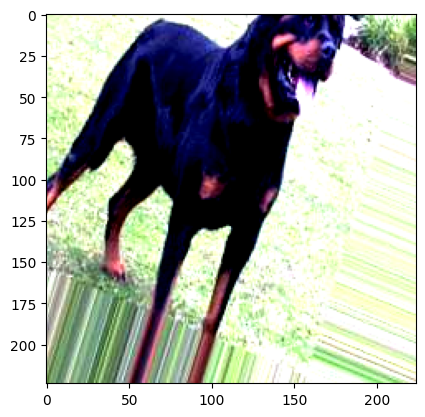

In [18]:
from PIL import Image
from torchvision import transforms

clases = ['dermatitis','pioderma','sarna','sano']


def get_transform(image_size):
    if image_size>50176:
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
         return transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


# Cargando la imagen
img = Image.open('./petnet_aug_2/aug_351_10.jpg') 

# Aplicando las transformaciones
# Obtener size de img
width, height = img.size

transform_testing = get_transform(width*height)

img = transform_testing(img).unsqueeze(0)



# Utilizando el tensor en el mismo device que el modelo en este caso CUDA
img = img.to(device)

# Pasando la imagen por el modelo
output = resnet50(img)

# Obteniendo el indice de la clase predicha
_, predicted = torch.max(output, 1)
print('Prediccion:', clases[predicted.item()])

# Mostrar la imagen junto a la predccion
img_show(utils.make_grid(img.cpu().data))


### Definiendo matrix de confusion

In [19]:
# Inicializamos el modelo en modo evaluacion
resnet50.eval()

# Guardamos los verdaderos y los predichos (labels)
true_labels = []
predicted_labels = []

# Iterate over the test data
for images, labels in test_loader:
    # Move the images and labels to the same device as the model
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = resnet50(images)

    # Get the predicted labels
    _, predicted = torch.max(outputs, 1)

    # Store the true and predicted labels
    true_labels.append(labels.cpu().numpy())
    predicted_labels.append(predicted.cpu().numpy())

# Flatten the lists of true and predicted labels
true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)


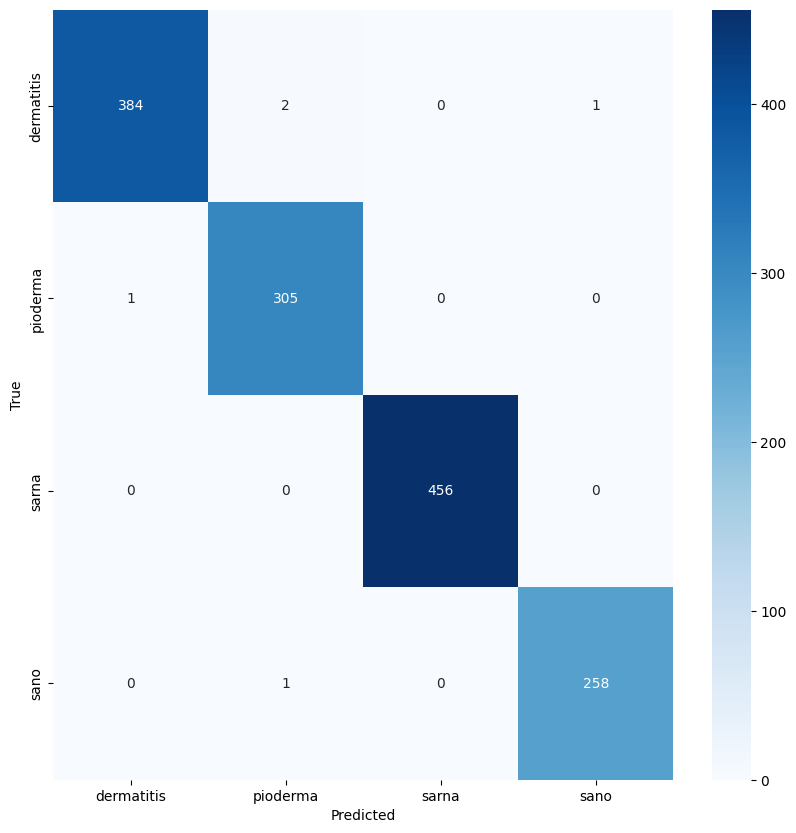

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a dictionary to map class indices to class names
class_names = {0: 'dermatitis', 1: 'pioderma', 2: 'sarna','3':'sano'}

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names.values(), 
            yticklabels=class_names.values())

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
from sklearn.metrics import precision_score

# Calculate precision for each class
precision = precision_score(true_labels, predicted_labels, average=None)

# Create a dictionary to map class indices to class names
class_names = {0: 'dermatitis', 1: 'pioderma', 2: 'sarna',3:'sano'}

# Print the precision for each class
for i, prec in enumerate(precision):
    print(f'Precision for {class_names[i]}: {prec:.2f}')

Precision for dermatitis: 1.00
Precision for pioderma: 0.99
Precision for sarna: 1.00
Precision for sano: 1.00


In [25]:
from sklearn.metrics import recall_score

# Calculate recall for each class
recall = recall_score(true_labels, predicted_labels, average=None)

# Create a dictionary to map class indices to class names
class_names = {0: 'dermatitis', 1: 'pioderma', 2: 'sarna',3:'sano'}

# Print the recall for each class
for i, rec in enumerate(recall):
    print(f'Recall for {class_names[i]}: {rec:.2f}')

Recall for dermatitis: 0.99
Recall for pioderma: 1.00
Recall for sarna: 1.00
Recall for sano: 1.00


In [26]:
from sklearn.metrics import f1_score

# Calculate F1 score for each class
f1 = f1_score(true_labels, predicted_labels, average=None)

# Create a dictionary to map class indices to class names
class_names = {0: 'dermatitis', 1: 'pioderma', 2: 'sarna',3:'sano'}

# Print the F1 score for each class
for i, f1s in enumerate(f1):
    print(f'F1 score for {class_names[i]}: {f1s:.2f}')

F1 score for dermatitis: 0.99
F1 score for pioderma: 0.99
F1 score for sarna: 1.00
F1 score for sano: 1.00


# Guardando el modelo

In [29]:
model_path=f'./model_petnet_{EPOCHS}_new.pth'

In [30]:
torch.save(resnet50.state_dict(), model_path)

# Cargando el modelo

In [2]:
from torchvision import models
import torch
model_path='./model_petnet_50_new.pth'
resnet50 = models.resnet50(weights=None)

# Adjust the output size of the fc layer to match the output size of the saved model parameters
num_ftrs = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_ftrs, 4)

# Load the trained model parameters
resnet50.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [3]:
resnet50 = resnet50.to(device='cuda')
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
def img_show_loaded_model(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediccion: dermatitis


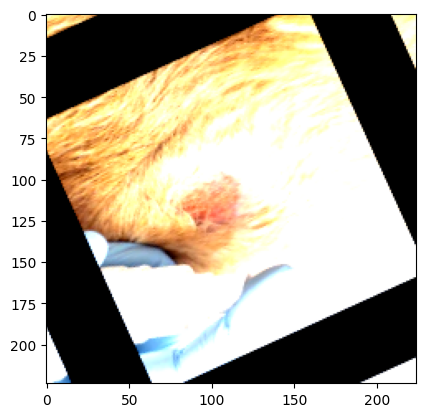

In [7]:
from PIL import Image
from torchvision import transforms
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clases = ['dermatitis','pioderma','sarna','sano']


def get_transform(image_size):
    if image_size>50176:
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
         return transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


# Cargando la imagen
img = Image.open('./petnet_data/288.png') 

# Aplicando las transformaciones
# Obtener size de img
width, height = img.size

transform_testing = get_transform(width*height)

img = transform_testing(img).unsqueeze(0)

# Utilizando el tensor en el mismo device que el modelo en este caso CUDA
img = img.to(device)

# Pasando la imagen por el modelo
output = resnet50(img)

# Obteniendo el indice de la clase predicha
_, predicted = torch.max(output, 1)
print('Prediccion:', clases[predicted.item()])

# Mostrar la imagen junto a la predccion
img_show_loaded_model(utils.make_grid(img.cpu().data))